In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from datetime import datetime, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import copy
from meteostat import Stations, Daily
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
path = "RawData"


def extract_date_time(filename):
    """
    extract the date and time from the filename
    :param filename:
    :return:
    """
    parts = filename.split('.')
    date = parts[1]
    time = parts[2]
    return date, time


def get_date(df, file):
    """get the date from the dataframe and the time from the filename and combine them into a datetime object
    :param df: dataframe containing the date
    :param file: filename containing the time
    :return: datetime object
    """
    #date_str = df[df.iloc[:, 2] == 1].iloc[0]['Date']
    date_str = str(file.split('.')[1])
    time_str = str(file.split('.')[2])
    #date = datetime.strptime(date_str, '%Y-%m-%d')
    date = datetime.strptime(date_str, '%Y%m%d')
    time_value = time(int(time_str), 0)
    combined_datetime = datetime.combine(date.date(), time_value)
    return combined_datetime


degree_days = 'gw_hdd'
ecmwf_files = glob.glob(path + f'/ecmwf.*.[01][02].{degree_days}.csv')
ecmwf_sorted_files = sorted(ecmwf_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[3:]

ecmwf_eps_files = glob.glob(path + f'/ecmwf-eps.*.[01][02].{degree_days}.csv')
ecmwf_eps_sorted_files = sorted(ecmwf_eps_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

gfs_ens_bc_files = glob.glob(path + f'/gfs-ens-bc.*.[01][02].{degree_days}.csv')
gfs_ens_bc_sorted_files = sorted(gfs_ens_bc_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]

cmc_ens_files = glob.glob(path + f'/cmc-ens.*.[01][02].{degree_days}.csv')
cmc_ens_sorted_files = sorted(cmc_ens_files, key=lambda x: (x.split('.')[1], x.split('.')[2]))[2:]
for _ in range(2):
    set1 = set((extract_date_time(filename) for filename in ecmwf_sorted_files))
    set2 = set((extract_date_time(filename) for filename in ecmwf_eps_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in set2]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if extract_date_time(filename) in set1]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in set1]

    master_set = set((extract_date_time(filename) for filename in cmc_ens_sorted_files))
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]

    master_set = set((extract_date_time(filename) for filename in gfs_ens_bc_sorted_files))

    ecmwf_sorted_files = [filename for filename in ecmwf_sorted_files if extract_date_time(filename) in master_set]
    ecmwf_eps_sorted_files = [filename for filename in ecmwf_eps_sorted_files if
                              extract_date_time(filename) in master_set]
    gfs_ens_bc_sorted_files = [filename for filename in gfs_ens_bc_sorted_files if
                               extract_date_time(filename) in master_set]
    cmc_ens_sorted_files = [filename for filename in cmc_ens_sorted_files if extract_date_time(filename) in master_set]

In [3]:
ecmwf_eps_change_df = pd.DataFrame(columns=['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12',
                                  'ecmwf-eps_13', 'ecmwf-eps_14'])

for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8, 14):
        changes.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_eps_change_df.columns, index=[date])
    ecmwf_eps_change_df = pd.concat([ecmwf_eps_change_df, new_row])

In [4]:
ecmwf_change_df = pd.DataFrame(columns=['ecmwf_diff_8', 'ecmwf_diff_9',])
for i in range(1, len(ecmwf_sorted_files)):
    ecmwf_df = pd.read_csv(ecmwf_sorted_files[i])
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1]) #one day behind

    ecmwf = ecmwf_df.iloc[8]
    ecmwf_eps = ecmwf_eps_df.iloc[9]

    date = get_date(ecmwf_df, ecmwf_sorted_files[i])
    prev_date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8,10):
        changes.append(ecmwf_df.iloc[day - offset]['Value'] - ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=ecmwf_change_df.columns, index=[date])
    ecmwf_change_df = pd.concat([ecmwf_change_df, new_row])

In [5]:
gfs_ens_bc_change_df = pd.DataFrame(columns=['gfs-ens-bc_9', 'gfs-ens-bc_10', 'gfs-ens-bc_11', 'gfs-ens-bc_12',
                                  'gfs-ens-bc_13', 'gfs-ens-bc_14'])

for i in range(1, len(gfs_ens_bc_sorted_files)):
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])

    date = get_date(gfs_ens_bc_df, gfs_ens_bc_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]
    if d2 != d1:
        offset = 1
    else:
        offset = 0

    changes = []
    for day in range(8, 14):
        changes.append(gfs_ens_bc_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=gfs_ens_bc_change_df.columns, index=[date])
    gfs_ens_bc_change_df = pd.concat([gfs_ens_bc_change_df, new_row])

In [6]:
cmc_ens_change_df = pd.DataFrame(columns=['cmc-ens_9', 'cmc-ens_10', 'cmc-ens_11', 'cmc-ens_12',
                                  'cmc-ens_13', 'cmc-ens_14'])

for i in range(1, len(cmc_ens_sorted_files)):
    cmc_ens_df = pd.read_csv(cmc_ens_sorted_files[i])
    gfs_ens_bc_df = pd.read_csv(gfs_ens_bc_sorted_files[i])
    date = get_date(cmc_ens_df, cmc_ens_sorted_files[i])

    changes = []
    for day in range(8, 14):
        changes.append(cmc_ens_df.iloc[day]['Value'] - gfs_ens_bc_df.iloc[day]['Value'])
    new_row = pd.DataFrame([changes], columns=cmc_ens_change_df.columns, index=[date])
    cmc_ens_change_df = pd.concat([cmc_ens_change_df, new_row])

In [7]:
day_8_error = pd.DataFrame(columns=['day_8_error'])
for i in range(1, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0
    day = 7
    changes = []
    changes.append(ecmwf_eps_df.iloc[day]['Value'] - prev_ecmwf_eps_df.iloc[day + offset]['Value'])
    new_row = pd.DataFrame([changes], columns=day_8_error.columns, index=[date])
    day_8_error = pd.concat([day_8_error, new_row])

In [8]:
errors_df = pd.DataFrame(columns=['error_9', 'error_10', 'error_11', 'error_12', 'error_13', 'error_14'])

for i in range(2, len(ecmwf_eps_sorted_files)):
    ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-1])
    prev_ecmwf_eps_df = pd.read_csv(ecmwf_eps_sorted_files[i-2])
    date = get_date(ecmwf_eps_df, ecmwf_eps_sorted_files[i])
    prev_date = get_date(prev_ecmwf_eps_df, ecmwf_eps_sorted_files[i-1])
    d2 = str(date)[:10]
    d1 = str(prev_date)[:10]

    if d2 != d1:
        offset = 1
    else:
        offset = 0

    errors = []
    for day in range(8, 14):
        errors.append(ecmwf_eps_df.iloc[day - offset]['Value'] - prev_ecmwf_eps_df.iloc[day]['Value'])
    new_row = pd.DataFrame([errors], columns=errors_df.columns, index=[date])
    errors_df = pd.concat([errors_df, new_row])

In [9]:
master_df = pd.concat([gfs_ens_bc_change_df, cmc_ens_change_df, ecmwf_change_df, errors_df, day_8_error, ecmwf_eps_change_df], axis=1)
master_df.fillna(0, inplace=True)
display(master_df[:5])

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,error_12,error_13,error_14,day_8_error,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.009,0.006,0.002,0.001,0.013,0.013,-0.006,-0.003,-0.001,-0.013,...,0.000,0.000,0.000,0.001,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,-0.003,-0.002,-0.001,-0.005,...,-0.002,0.002,-0.002,0.005,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,0.003,0.002,0.002,0.006,0.009,0.020,-0.004,-0.002,-0.006,-0.009,...,0.001,-0.003,0.001,-0.001,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,-0.002,-0.002,-0.004,-0.008,...,0.001,-0.001,0.003,0.003,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.001,0.002,0.002,0.007,0.019,0.021,-0.001,-0.003,-0.008,-0.022,...,0.000,0.001,0.004,0.000,0.000,-0.001,-0.001,-0.002,0.000,-0.001


random forest

In [10]:
X = master_df.iloc[:, :-6]
y = master_df.iloc[:, -6:]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=42)

In [12]:
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1854454979319896


RNN

In [13]:
input_features = master_df.iloc[:, :-6].values ** 2
target_variables = master_df.iloc[:, -6:].values

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    input_features, target_variables, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False)

# Scale the input features based on the training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Scale the validation and test data based on the training data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data to PyTorch tensors

X_train_tensor = torch.Tensor(X_train_scaled)
y_train_tensor = torch.Tensor(y_train)
X_val_tensor = torch.Tensor(X_val_scaled)
y_val_tensor = torch.Tensor(y_val)
X_test_tensor = torch.Tensor(X_test_scaled)
y_test_tensor = torch.Tensor(y_test)

In [14]:
#benchmark error
total_mse = 0
c = 0
for i in range(1, len(y_test_tensor)):
    #mse = mean_squared_error(y_test_tensor[i], y_test_tensor[i-1])
    mse = mean_squared_error(y_test_tensor[i], [0,0,0,0,0,0])
    total_mse += mse
    c += 1

total_mse/c

0.16695826363327243

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 64)  # Dense layer with 64 units
        self.fc2 = nn.Linear(64, output_size)  # Final output layer

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = F.relu(out)  # Apply ReLU activation between LSTM and first dense layer
        out = self.fc1(out[:, -1, :])
        out = F.relu(out)  # Apply ReLU activation to the output of the first dense layer
        out = self.fc2(out)

        return out

In [16]:
input_size = X_train_tensor.shape[1]
output_size = y_train_tensor.shape[1]
hidden_size = 64
num_layers = 2
dropout = 0.3
lr = 0.01

In [17]:
model = RNN(input_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)

In [27]:
num_epochs = 100
sequence_length = 5  # Number of previous days to consider

best_loss = float('inf')
best_model = None
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    # Loop through each sequence in the training data
    for i in range(sequence_length, X_train_tensor.shape[0]):
        # Extract the current sequence and target
        input_seq = X_train_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_train_tensor[i]

        # Forward pass
        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / (X_train_tensor.shape[0] - sequence_length)
    train_losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss}')

    # Validation stage
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_val_loss = 0

        for i in range(sequence_length, X_val_tensor.shape[0]):
            input_seq = X_val_tensor[i - sequence_length:i].view(1, sequence_length, -1)
            target_seq = y_val_tensor[i]

            output = model(input_seq)
            val_loss = criterion(output, target_seq.unsqueeze(0))

            total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / (X_val_tensor.shape[0] - sequence_length)
        val_losses.append(average_val_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {average_val_loss}')

        # Check if current model is the best based on validation loss
        if average_val_loss < best_loss:
            best_loss = average_val_loss
            best_model = copy.deepcopy(model)

# After training, use the best model for testing
model = best_model

Epoch [1/100], Training Loss: 0.1871006441203223
Epoch [1/100], Validation Loss: 0.18947593587361003
Epoch [2/100], Training Loss: 0.18674874982800432
Epoch [2/100], Validation Loss: 0.18964706866258407
Epoch [3/100], Training Loss: 0.18637060701821423
Epoch [3/100], Validation Loss: 0.18965568341450365
Epoch [4/100], Training Loss: 0.1867384647969386
Epoch [4/100], Validation Loss: 0.18956347593957024
Epoch [5/100], Training Loss: 0.1867511325163515
Epoch [5/100], Validation Loss: 0.18975623835830369
Epoch [6/100], Training Loss: 0.1862885603395183
Epoch [6/100], Validation Loss: 0.1896915113302154
Epoch [7/100], Training Loss: 0.18674163050103712
Epoch [7/100], Validation Loss: 0.18961945383861714
Epoch [8/100], Training Loss: 0.18652984291430924
Epoch [8/100], Validation Loss: 0.1896238616482118
Epoch [9/100], Training Loss: 0.18669914157364173
Epoch [9/100], Validation Loss: 0.18961980781134993
Epoch [10/100], Training Loss: 0.18725305032235326
Epoch [10/100], Validation Loss: 0.18

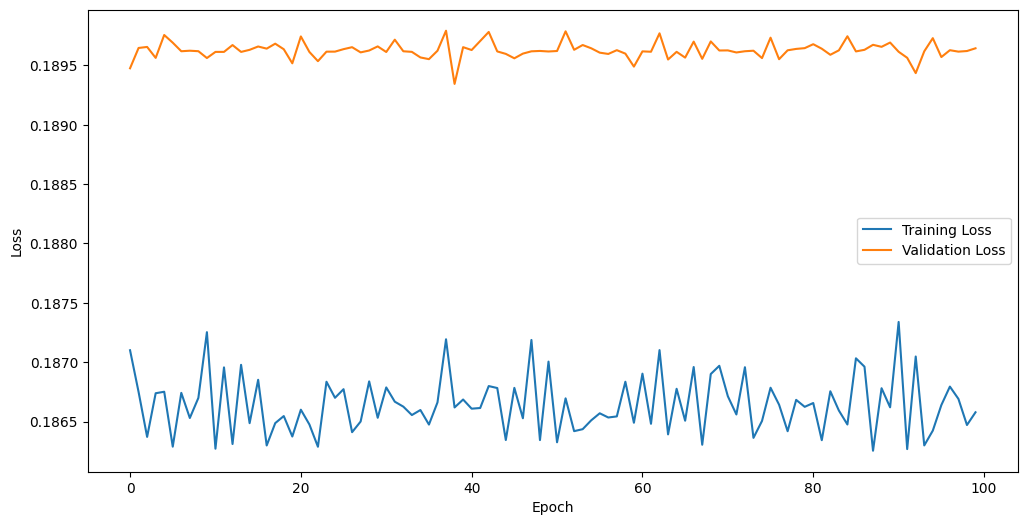

In [28]:
def plot_losses(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train_losses, label='Training Loss')
    ax.plot(val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()
plot_losses(train_losses, val_losses)

In [29]:
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    test_loss = 0.0
    predictions = []

    for i in range(sequence_length, X_test_tensor.shape[0]):
        input_seq = X_test_tensor[i - sequence_length:i].view(1, sequence_length, -1)
        target_seq = y_test_tensor[i]

        output = model(input_seq)
        loss = criterion(output, target_seq.unsqueeze(0))

        test_loss += loss.item()

        # Extract the scalar value from the tensor and append it to predictions
        predictions.append(output.squeeze().tolist())

    average_test_loss = test_loss / (X_test_tensor.shape[0] - sequence_length)
    print(f'Test Loss: {average_test_loss}')

    # Convert the predictions and target values to numpy arrays
    predictions = np.array(predictions)
    targets = y_test_tensor[sequence_length:].numpy()

    # Evaluate the performance using appropriate metrics
    # For example, calculate mean squared error (MSE)
    mse = mean_squared_error(targets, predictions)
    print(f'Mean Squared Error (MSE): {mse}')

Test Loss: 0.16782047505148642
Mean Squared Error (MSE): 0.16782047588214263


In [30]:
def prediction(input):
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        input_seq = torch.tensor(input).view(1, sequence_length, -1)
        output = model(input_seq)
        return output.squeeze().tolist()

In [31]:
pred = prediction(X_test_tensor[-5:])

In [32]:
pred

[-0.00606852862983942,
 -0.0033341646194458008,
 -0.004950466100126505,
 0.0020900126546621323,
 -0.000896872952580452,
 0.00398428738117218]

In [33]:
y_test_tensor[-1]

tensor([ 0.0000, -0.1690, -0.2710,  0.0250, -0.0080, -0.0780])

# Autogloun

In [18]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.common.utils.utils import setup_outputdir
from autogluon.core.utils.loaders import load_pkl
from autogluon.core.utils.savers import save_pkl
import os.path

In [20]:
train_len = 0.8
train_data = TabularDataset(master_df[:int(len(master_df)*train_len)])
test_data = TabularDataset(master_df[int(len(master_df)*train_len):])

In [25]:
labels = ['ecmwf-eps_9', 'ecmwf-eps_10', 'ecmwf-eps_11', 'ecmwf-eps_12', 'ecmwf-eps_13',
          'ecmwf-eps_14']
save_path = 'models'

In [22]:
display(train_data.head())

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,error_12,error_13,error_14,day_8_error,ecmwf-eps_9,ecmwf-eps_10,ecmwf-eps_11,ecmwf-eps_12,ecmwf-eps_13,ecmwf-eps_14
2018-07-11 00:00:00,0.009,0.006,0.002,0.001,0.013,0.013,-0.006,-0.003,-0.001,-0.013,...,0.000,0.000,0.000,0.001,0.001,-0.001,0.000,0.000,0.000,0.000
2018-07-11 12:00:00,0.004,0.001,0.000,0.005,0.008,0.018,-0.003,-0.002,-0.001,-0.005,...,-0.002,0.002,-0.002,0.005,0.001,0.000,-0.001,-0.001,-0.001,-0.001
2018-07-12 00:00:00,0.003,0.002,0.002,0.006,0.009,0.020,-0.004,-0.002,-0.006,-0.009,...,0.001,-0.003,0.001,-0.001,-0.001,-0.001,0.000,0.000,-0.001,0.001
2018-07-12 12:00:00,0.001,0.002,0.004,0.009,0.021,0.015,-0.002,-0.002,-0.004,-0.008,...,0.001,-0.001,0.003,0.003,0.000,-0.001,0.001,0.001,0.006,0.003
2018-07-13 00:00:00,0.001,0.002,0.002,0.007,0.019,0.021,-0.001,-0.003,-0.008,-0.022,...,0.000,0.001,0.004,0.000,0.000,-0.001,-0.001,-0.002,0.000,-0.001


In [23]:
class MultilabelPredictor():
    """ Tabular Predictor for predicting multiple columns in table.
        Creates multiple TabularPredictor objects which you can also use individually.
        You can access the TabularPredictor for a particular label via: `multilabel_predictor.get_predictor(label_i)`

        Parameters
        ----------
        labels : List[str]
            The ith element of this list is the column (i.e. `label`) predicted by the ith TabularPredictor stored in this object.
        path : str, default = None
            Path to directory where models and intermediate outputs should be saved.
            If unspecified, a time-stamped folder called "AutogluonModels/ag-[TIMESTAMP]" will be created in the working directory to store all models.
            Note: To call `fit()` twice and save all results of each fit, you must specify different `path` locations or don't specify `path` at all.
            Otherwise files from first `fit()` will be overwritten by second `fit()`.
            Caution: when predicting many labels, this directory may grow large as it needs to store many TabularPredictors.
        problem_types : List[str], default = None
            The ith element is the `problem_type` for the ith TabularPredictor stored in this object.
        eval_metrics : List[str], default = None
            The ith element is the `eval_metric` for the ith TabularPredictor stored in this object.
        consider_labels_correlation : bool, default = True
            Whether the predictions of multiple labels should account for label correlations or predict each label independently of the others.
            If True, the ordering of `labels` may affect resulting accuracy as each label is predicted conditional on the previous labels appearing earlier in this list (i.e. in an auto-regressive fashion).
            Set to False if during inference you may want to individually use just the ith TabularPredictor without predicting all the other labels.
        kwargs :
            Arguments passed into the initialization of each TabularPredictor.

    """

    multi_predictor_file = 'multilabel_predictor.pkl'

    def __init__(self, labels, path=None, problem_types=None, eval_metrics=None, consider_labels_correlation=True, **kwargs):
        if len(labels) < 2:
            raise ValueError("MultilabelPredictor is only intended for predicting MULTIPLE labels (columns), use TabularPredictor for predicting one label (column).")
        if (problem_types is not None) and (len(problem_types) != len(labels)):
            raise ValueError("If provided, `problem_types` must have same length as `labels`")
        if (eval_metrics is not None) and (len(eval_metrics) != len(labels)):
            raise ValueError("If provided, `eval_metrics` must have same length as `labels`")
        self.path = setup_outputdir(path, warn_if_exist=False)
        self.labels = labels
        self.consider_labels_correlation = consider_labels_correlation
        self.predictors = {}  # key = label, value = TabularPredictor or str path to the TabularPredictor for this label
        if eval_metrics is None:
            self.eval_metrics = {}
        else:
            self.eval_metrics = {labels[i] : eval_metrics[i] for i in range(len(labels))}
        problem_type = None
        eval_metric = None
        for i in range(len(labels)):
            label = labels[i]
            path_i = self.path + "Predictor_" + label
            if problem_types is not None:
                problem_type = problem_types[i]
            if eval_metrics is not None:
                eval_metric = eval_metrics[i]
            self.predictors[label] = TabularPredictor(label=label, problem_type=problem_type, eval_metric=eval_metric, path=path_i, **kwargs)

    def fit(self, train_data, tuning_data=None, **kwargs):
        """ Fits a separate TabularPredictor to predict each of the labels.

            Parameters
            ----------
            train_data, tuning_data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                See documentation for `TabularPredictor.fit()`.
            kwargs :
                Arguments passed into the `fit()` call for each TabularPredictor.
        """
        if isinstance(train_data, str):
            train_data = TabularDataset(train_data)
        if tuning_data is not None and isinstance(tuning_data, str):
            tuning_data = TabularDataset(tuning_data)
        train_data_og = train_data.copy()
        if tuning_data is not None:
            tuning_data_og = tuning_data.copy()
        else:
            tuning_data_og = None
        save_metrics = len(self.eval_metrics) == 0
        for i in range(len(self.labels)):
            label = self.labels[i]
            predictor = self.get_predictor(label)
            if not self.consider_labels_correlation:
                labels_to_drop = [l for l in self.labels if l != label]
            else:
                labels_to_drop = [self.labels[j] for j in range(i+1, len(self.labels))]
            train_data = train_data_og.drop(labels_to_drop, axis=1)
            if tuning_data is not None:
                tuning_data = tuning_data_og.drop(labels_to_drop, axis=1)
            print(f"Fitting TabularPredictor for label: {label} ...")
            predictor.fit(train_data=train_data, tuning_data=tuning_data, **kwargs)
            self.predictors[label] = predictor.path
            if save_metrics:
                self.eval_metrics[label] = predictor.eval_metric
        self.save()

    def predict(self, data, **kwargs):
        """ Returns DataFrame with label columns containing predictions for each label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. If label columns are present in this data, they will be ignored. See documentation for `TabularPredictor.predict()`.
            kwargs :
                Arguments passed into the predict() call for each TabularPredictor.
        """
        return self._predict(data, as_proba=False, **kwargs)

    def predict_proba(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `predict_proba()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to make predictions for. See documentation for `TabularPredictor.predict()` and `TabularPredictor.predict_proba()`.
            kwargs :
                Arguments passed into the `predict_proba()` call for each TabularPredictor (also passed into a `predict()` call).
        """
        return self._predict(data, as_proba=True, **kwargs)

    def evaluate(self, data, **kwargs):
        """ Returns dict where each key is a label and the corresponding value is the `evaluate()` output for just that label.

            Parameters
            ----------
            data : str or autogluon.tabular.TabularDataset or pd.DataFrame
                Data to evalate predictions of all labels for, must contain all labels as columns. See documentation for `TabularPredictor.evaluate()`.
            kwargs :
                Arguments passed into the `evaluate()` call for each TabularPredictor (also passed into the `predict()` call).
        """
        data = self._get_data(data)
        eval_dict = {}
        for label in self.labels:
            print(f"Evaluating TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            eval_dict[label] = predictor.evaluate(data, **kwargs)
            if self.consider_labels_correlation:
                data[label] = predictor.predict(data, **kwargs)
        return eval_dict

    def save(self):
        """ Save MultilabelPredictor to disk. """
        for label in self.labels:
            if not isinstance(self.predictors[label], str):
                self.predictors[label] = self.predictors[label].path
        save_pkl.save(path=self.path+self.multi_predictor_file, object=self)
        print(f"MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('{self.path}')")

    @classmethod
    def load(cls, path):
        """ Load MultilabelPredictor from disk `path` previously specified when creating this MultilabelPredictor. """
        path = os.path.expanduser(path)
        if path[-1] != os.path.sep:
            path = path + os.path.sep
        return load_pkl.load(path=path+cls.multi_predictor_file)

    def get_predictor(self, label):
        """ Returns TabularPredictor which is used to predict this label. """
        predictor = self.predictors[label]
        if isinstance(predictor, str):
            return TabularPredictor.load(path=predictor)
        return predictor

    def _get_data(self, data):
        if isinstance(data, str):
            return TabularDataset(data)
        return data.copy()

    def _predict(self, data, as_proba=False, **kwargs):
        data = self._get_data(data)
        if as_proba:
            predproba_dict = {}
        for label in self.labels:
            print(f"Predicting with TabularPredictor for label: {label} ...")
            predictor = self.get_predictor(label)
            if as_proba:
                predproba_dict[label] = predictor.predict_proba(data, as_multiclass=True, **kwargs)
            data[label] = predictor.predict(data, **kwargs)
        if not as_proba:
            return data[self.labels]
        else:
            return predproba_dict

In [46]:
multi_predictor = MultilabelPredictor(labels=labels, path=save_path)

In [48]:
multi_predictor.fit(train_data, presets='best_quality')

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ...
AutoGluon will save models to "models/Predictor_ecmwf-eps_9/"
AutoGluon Version:  0.7.0
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Mon Apr 24 20:53:44 PDT 2023; root:xnu-8796.121.2~5/RELEASE_ARM64_T8103
Train Data Rows:    2786
Train Data Columns: 21
Label Column: ecmwf-eps_9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (0.9200000000000017, -4.757999999999999, -0.02286, 0.21071)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Featur

Fitting TabularPredictor for label: ecmwf-eps_9 ...


		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/n

Fitting TabularPredictor for label: ecmwf-eps_10 ...


		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)
Fitting model: RandomForestMSE_BAG_L1 ...
	-0.1204	 = Validation score   (-root_mean_squared_error)
	2.54s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting 

Fitting TabularPredictor for label: ecmwf-eps_11 ...


		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)
Fitting model: RandomForestMSE_BAG_L1 ...
	-0.2349	 = Validation score   (-root_mean_squared_error)
	3.12s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting 

Fitting TabularPredictor for label: ecmwf-eps_12 ...


		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/n

Fitting TabularPredictor for label: ecmwf-eps_13 ...


	-0.5453	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)


Fitting TabularPredictor for label: ecmwf-eps_14 ...


		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: <D21A7969-4567-3BC7-94ED-6A9E83AE9D78> /Users/nickgault/opt/miniconda3/envs/Kayak/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file, not in dyld cache)
Fitting model: LightGBM_BAG_L1 ...
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
		`import lightgbm` failed. If you are using Mac OSX, Please try 'brew install libomp'. Detailed info: dlopen(/Users/n

MultilabelPredictor saved to disk. Load with: MultilabelPredictor.load('models/')


In [49]:
test_data_nolab = test_data.drop(columns=labels)
test_data_nolab.head()

,gfs-ens-bc_9,gfs-ens-bc_10,gfs-ens-bc_11,gfs-ens-bc_12,gfs-ens-bc_13,gfs-ens-bc_14,cmc-ens_9,cmc-ens_10,cmc-ens_11,cmc-ens_12,...,cmc-ens_14,ecmwf_diff_8,ecmwf_diff_9,error_9,error_10,error_11,error_12,error_13,error_14,day_8_error
2022-06-03 00:00:00,-0.056,0.284,0.235,-0.012,-0.186,-0.254,-0.062,-0.088,-0.044,0.043,...,0.115,-0.089,-0.174,-0.140,-0.468,0.275,-0.221,-0.289,0.201,-0.094
2022-06-03 12:00:00,0.245,0.149,0.015,-0.177,-0.229,-0.307,0.023,-0.067,-0.048,0.265,...,0.162,-0.023,-0.057,0.297,-0.509,0.013,0.016,-0.341,-0.200,0.158
2022-06-04 00:00:00,0.091,0.101,-0.160,-0.319,-0.295,-0.112,-0.053,0.052,0.277,0.186,...,-0.024,-0.017,-0.042,-0.233,0.392,-0.141,-0.121,0.137,0.011,-0.031
2022-06-04 12:00:00,0.102,-0.112,-0.176,-0.194,-0.116,-0.056,-0.052,0.000,0.228,0.071,...,-0.171,0.030,-0.081,-0.512,0.007,-0.027,-0.326,-0.303,-0.023,0.147
2022-06-05 00:00:00,0.016,-0.119,-0.257,-0.154,-0.074,0.054,0.053,0.370,0.110,-0.109,...,0.240,-0.118,-0.117,0.628,0.018,-0.096,0.174,0.147,-0.022,-0.065


In [50]:
predictions = multi_predictor.predict(test_data_nolab)
print("Predictions:  \n", predictions)

Predicting with TabularPredictor for label: ecmwf-eps_9 ...
Predicting with TabularPredictor for label: ecmwf-eps_10 ...
Predicting with TabularPredictor for label: ecmwf-eps_11 ...
Predicting with TabularPredictor for label: ecmwf-eps_12 ...
Predicting with TabularPredictor for label: ecmwf-eps_13 ...
Predicting with TabularPredictor for label: ecmwf-eps_14 ...
Predictions:  
                      ecmwf-eps_9  ecmwf-eps_10  ecmwf-eps_11  ecmwf-eps_12  \
2022-06-03 00:00:00    -0.070274     -0.054683     -0.014851     -0.040611   
2022-06-03 12:00:00     0.019687      0.005112      0.005042     -0.007257   
2022-06-04 00:00:00    -0.012484     -0.004831     -0.020349     -0.035969   
2022-06-04 12:00:00     0.028655     -0.030362     -0.029364     -0.029605   
2022-06-05 00:00:00    -0.070877     -0.065110     -0.076699     -0.045437   
...                          ...           ...           ...           ...   
2023-05-15 00:00:00     0.100431      0.041367     -0.120704     -0.26401

In [51]:
display(predictions.iloc[-2])

ecmwf-eps_9     0.059725
ecmwf-eps_10    0.194602
ecmwf-eps_11    0.297363
ecmwf-eps_12    0.002931
ecmwf-eps_13   -0.175378
ecmwf-eps_14   -0.194028
Name: 2023-05-16 12:00:00, dtype: float32

In [52]:
test_data[labels].iloc[-2]

ecmwf-eps_9     0.261
ecmwf-eps_10    0.335
ecmwf-eps_11    0.252
ecmwf-eps_12    0.221
ecmwf-eps_13    0.176
ecmwf-eps_14    0.538
Name: 2023-05-16 12:00:00, dtype: float64

In [53]:
evaluations = multi_predictor.evaluate(test_data)
#print(evaluations)
print("Evaluated using metrics:", multi_predictor.eval_metrics)

Evaluation: root_mean_squared_error on test data: -0.08023007545311743
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.08023007545311743,
    "mean_squared_error": -0.006436865007212917,
    "mean_absolute_error": -0.05291710419293033,
    "r2": 0.8108099725454907,
    "pearsonr": 0.9010937094084588,
    "median_absolute_error": -0.028835937261582956
}


Evaluating TabularPredictor for label: ecmwf-eps_9 ...


Evaluating TabularPredictor for label: ecmwf-eps_10 ...


Evaluation: root_mean_squared_error on test data: -0.11082954443475555
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.11082954443475555,
    "mean_squared_error": -0.012283187919615454,
    "mean_absolute_error": -0.07472288912346754,
    "r2": 0.6756541939793443,
    "pearsonr": 0.8232688610737003,
    "median_absolute_error": -0.04603454846143684
}


Evaluating TabularPredictor for label: ecmwf-eps_11 ...


Evaluation: root_mean_squared_error on test data: -0.21695129123551476
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.21695129123551476,
    "mean_squared_error": -0.04706786276875714,
    "mean_absolute_error": -0.14032097252547607,
    "r2": 0.3058559574307328,
    "pearsonr": 0.553666118289079,
    "median_absolute_error": -0.07729820585250913
}


Evaluating TabularPredictor for label: ecmwf-eps_12 ...


Evaluation: root_mean_squared_error on test data: -0.358465200581571
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.358465200581571,
    "mean_squared_error": -0.12849730002798593,
    "mean_absolute_error": -0.2250503711142715,
    "r2": 0.14844945212599936,
    "pearsonr": 0.3869007581003848,
    "median_absolute_error": -0.13130800652503893
}


Evaluating TabularPredictor for label: ecmwf-eps_13 ...


Evaluation: root_mean_squared_error on test data: -0.4945915091799656
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.4945915091799656,
    "mean_squared_error": -0.24462076095291596,
    "mean_absolute_error": -0.31190416122347253,
    "r2": 0.12786390743800213,
    "pearsonr": 0.3582405521096596,
    "median_absolute_error": -0.17864633360505106
}
Evaluation: root_mean_squared_error on test data: -0.6084669201391874
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -0.6084669201391874,
    "mean_squared_error": -0.37023199290366826,
    "mean_absolute_error": -0.39079344333281113,
    "r2": 0.12233431197612399,
    "pearsonr": 0.350831916172944,
    "median_absolute_error": -0.22501058137416763
}


Evaluating TabularPredictor for label: ecmwf-eps_14 ...
Evaluated using metrics: {'ecmwf-eps_9': root_mean_squared_error, 'ecmwf-eps_10': root_mean_squared_error, 'ecmwf-eps_11': root_mean_squared_error, 'ecmwf-eps_12': root_mean_squared_error, 'ecmwf-eps_13': root_mean_squared_error, 'ecmwf-eps_14': root_mean_squared_error}


In [54]:
evaluations

{'ecmwf-eps_9': {'root_mean_squared_error': -0.08023007545311743,
  'mean_squared_error': -0.006436865007212917,
  'mean_absolute_error': -0.05291710419293033,
  'r2': 0.8108099725454907,
  'pearsonr': 0.9010937094084588,
  'median_absolute_error': -0.028835937261582956},
 'ecmwf-eps_10': {'root_mean_squared_error': -0.11082954443475555,
  'mean_squared_error': -0.012283187919615454,
  'mean_absolute_error': -0.07472288912346754,
  'r2': 0.6756541939793443,
  'pearsonr': 0.8232688610737003,
  'median_absolute_error': -0.04603454846143684},
 'ecmwf-eps_11': {'root_mean_squared_error': -0.21695129123551476,
  'mean_squared_error': -0.04706786276875714,
  'mean_absolute_error': -0.14032097252547607,
  'r2': 0.3058559574307328,
  'pearsonr': 0.553666118289079,
  'median_absolute_error': -0.07729820585250913},
 'ecmwf-eps_12': {'root_mean_squared_error': -0.358465200581571,
  'mean_squared_error': -0.12849730002798593,
  'mean_absolute_error': -0.2250503711142715,
  'r2': 0.1484494521259993

In [55]:
predictor_class = multi_predictor.get_predictor('ecmwf-eps_9')
predictor_class.leaderboard(silent=True)

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.095835,0.171864,18.375258,0.000289,0.132230,2,True,9
1,NeuralNetFastAI_BAG_L1,-0.097150,0.051237,15.458665,0.051237,15.458665,1,True,6
2,WeightedEnsemble_L3,-0.109854,0.597098,99.958364,0.000304,0.111628,3,True,16
3,NeuralNetFastAI_BAG_L2,-0.109971,0.472545,99.183259,0.048928,14.901001,2,True,13
4,ExtraTreesMSE_BAG_L2,-0.118655,0.547865,84.945735,0.124248,0.663477,2,True,12
5,ExtraTreesMSE_BAG_L1,-0.118742,0.118717,0.542624,0.118717,0.542624,1,True,5
6,NeuralNetTorch_BAG_L2,-0.119436,0.472646,125.935994,0.049029,41.653736,2,True,15
7,RandomForestMSE_BAG_L1,-0.120014,0.120338,2.784363,0.120338,2.784363,1,True,3
8,RandomForestMSE_BAG_L2,-0.120406,0.542214,87.558872,0.118597,3.276614,2,True,10
9,CatBoost_BAG_L2,-0.120425,0.437143,92.961455,0.013526,8.679197,2,True,11
